# Example on the impact of Resampling: Credit Card Fraud Data

We will now combine our previous discussions to investigate the effect of the resampling techniques discussed on our model performance. This time, we will use `imblearn`'s implementation of the sampling methods. We will use all default parameters for the models (no optimization yet). Again, we will use the **credit card fraud dataset**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from tqdm import tqdm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import warnings
warnings.filterwarnings("ignore")

# metrics
from imblearn.metrics import sensitivity_score, geometric_mean_score

#resampling methods
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# pipeline
from imblearn.pipeline import Pipeline

## Prepare Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data_dir = '/content/drive/MyDrive/MSDS-TERM4/ML2/DATA-IMBALANCE/'

In [7]:
df = pd.read_csv(data_dir + 'credit_card.csv')
df.head(3)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.611712,-0.769705,-0.149759,-0.224877,2.028577,-2.019887,0.292491,-0.523020,0.358468,0.070050,...,-0.075208,0.045536,0.380739,0.023440,-2.220686,-0.201146,0.066501,0.221180,1.79,0
1,-0.814682,1.319219,1.329415,0.027273,-0.284871,-0.653985,0.321552,0.435975,-0.704298,-0.600684,...,-0.128619,-0.368565,0.090660,0.401147,-0.261034,0.080621,0.162427,0.059456,1.98,0
2,-0.318193,1.118618,0.969864,-0.127052,0.569563,-0.532484,0.706252,-0.064966,-0.463271,-0.528357,...,-0.305402,-0.774704,-0.123884,-0.495687,-0.018148,0.121679,0.249050,0.092516,0.89,0


In [8]:
# Split into trainval and holdout
X, y = df.drop('Class', axis=1), df['Class']

(X_trainval, X_holdout, y_trainval, y_holdout) = train_test_split(X, y,
                                                                  random_state=143,
                                                                  test_size=0.25,
                                                                  stratify=y)

In [9]:
models_dict = {
    'KNeighborsClassifier': KNeighborsClassifier(),
    'LogisticRegressor': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier(random_state=143),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=143),
    'GradientBoostingClassifier': GradientBoostingClassifier(random_state=143)
}

## No Resampling

In [10]:
skf = StratifiedKFold(n_splits=5)

res = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_rec_scores = []
    val_gmean_scores = []

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time() # for logging run times

        # fit
        model.fit(X_train, y_train)

        #predict
        val_preds = model.predict(X_val)

        val_rec_score = sensitivity_score(y_val, val_preds)
        val_gmean_score = geometric_mean_score(y_val, val_preds)

        end_time = time.time() # for logging run times

        val_rec_scores.append(val_rec_score)
        val_gmean_scores.append(val_gmean_score)

    res[model_name] = {
        'ave_val_recall':np.mean(val_rec_scores) * 100,
        'ave_val_gmean_score':np.mean(val_gmean_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
res = pd.DataFrame(res).T
display(res)

100%|██████████| 5/5 [03:07<00:00, 37.55s/it]

Report Generated in 187.77 seconds


,ave_val_recall,ave_val_gmean_score,run_time
KNeighborsClassifier,41.428571,62.403849,0.714756
LogisticRegressor,56.428571,74.945992,0.567864
RandomForestClassifier,72.857143,85.173038,7.443133
DecisionTreeClassifier,65.714286,79.632569,0.628346
GradientBoostingClassifier,65.000000,80.199651,28.341729


## With Resampling
### Random Undersampling

In [ ]:
skf = StratifiedKFold(n_splits=5)

undersampler = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_rec_scores = []
    val_gmean_scores = []

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time() # for logging run times

        pipeline = Pipeline([('RandomUnderSampler',
                              RandomUnderSampler(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)

        val_rec_score = sensitivity_score(y_val, val_preds)
        val_gmean_score = geometric_mean_score(y_val, val_preds)

        end_time = time.time() # for logging run times

        val_rec_scores.append(val_rec_score)
        val_gmean_scores.append(val_gmean_score)

    undersampler[model_name] = {
        'ave_val_recall':np.mean(val_rec_scores) * 100,
        'ave_val_gmean_score':np.mean(val_gmean_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
undersampler = pd.DataFrame(undersampler).T
display(undersampler)

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]

Report Generated in 8.20 seconds


,ave_val_recall,ave_val_gmean_score,run_time
KNeighborsClassifier,60.000000,74.324114,1.129671
LogisticRegressor,91.428571,93.082760,0.057002
RandomForestClassifier,88.928571,93.144773,0.213891
DecisionTreeClassifier,86.428571,87.526245,0.020422
GradientBoostingClassifier,83.214286,86.020947,0.205410


### Random Oversampling

In [ ]:
skf = StratifiedKFold(n_splits=5)

oversampler = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_rec_scores = []
    val_gmean_scores = []

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time() # for logging run times

        pipeline = Pipeline([('RandomOverSampler',
                              RandomOverSampler(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)

        val_rec_score = sensitivity_score(y_val, val_preds)
        val_gmean_score = geometric_mean_score(y_val, val_preds)

        end_time = time.time() # for logging run times

        val_rec_scores.append(val_rec_score)
        val_gmean_scores.append(val_gmean_score)

    oversampler[model_name] = {
        'ave_val_recall':np.mean(val_rec_scores) * 100,
        'ave_val_gmean_score':np.mean(val_gmean_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
oversampler = pd.DataFrame(oversampler).T
display(oversampler)

100%|██████████| 5/5 [03:53<00:00, 46.61s/it]

Report Generated in 233.05 seconds


,ave_val_recall,ave_val_gmean_score,run_time
KNeighborsClassifier,54.642857,72.909206,5.694188
LogisticRegressor,81.428571,89.224824,0.720870
RandomForestClassifier,65.000000,79.971498,5.714237
DecisionTreeClassifier,62.142857,76.057812,0.498761
GradientBoostingClassifier,75.357143,86.146904,33.328489


### SMOTE

In [ ]:
skf = StratifiedKFold(n_splits=5)

smote = {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_rec_scores = []
    val_gmean_scores = []

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time() # for logging run times

        pipeline = Pipeline([('SMOTEr',
                              SMOTE(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)

        val_rec_score = sensitivity_score(y_val, val_preds)
        val_gmean_score = geometric_mean_score(y_val, val_preds)

        end_time = time.time() # for logging run times

        val_rec_scores.append(val_rec_score)
        val_gmean_scores.append(val_gmean_score)

    smote[model_name] = {
        'ave_val_recall':np.mean(val_rec_scores) * 100,
        'ave_val_gmean_score':np.mean(val_gmean_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
smote = pd.DataFrame(smote).T
display(smote)

100%|██████████| 5/5 [07:07<00:00, 85.50s/it] 

Report Generated in 427.54 seconds


,ave_val_recall,ave_val_gmean_score,run_time
KNeighborsClassifier,86.428571,92.210846,7.364380
LogisticRegressor,83.928571,91.021798,0.471656
RandomForestClassifier,73.214286,84.729091,18.054794
DecisionTreeClassifier,62.500000,78.399099,2.661111
GradientBoostingClassifier,78.214286,88.299406,58.026891


### ADASYN

In [ ]:
skf = StratifiedKFold(n_splits=5)

adasyn= {}

# log start time
total_start = time.time()

for model_name, model in tqdm(models_dict.items()):
    val_rec_scores = []
    val_gmean_scores = []

    for train_index, val_index in skf.split(X_trainval, y_trainval):
        X_train, X_val = X_trainval.iloc[train_index], X_trainval.iloc[val_index]
        y_train, y_val = y_trainval.iloc[train_index], y_trainval.iloc[val_index]

        start_time = time.time() # for logging run times

        pipeline = Pipeline([('ADASYN',
                              ADASYN(random_state=143)),
                             (model_name, model)])
        pipeline.fit(X_train, y_train)

        train_preds = pipeline.predict(X_train)
        val_preds = pipeline.predict(X_val)

        val_rec_score = sensitivity_score(y_val, val_preds)
        val_gmean_score = geometric_mean_score(y_val, val_preds)

        end_time = time.time() # for logging run times

        val_rec_scores.append(val_rec_score)
        val_gmean_scores.append(val_gmean_score)

    adasyn[model_name] = {
        'ave_val_recall':np.mean(val_rec_scores) * 100,
        'ave_val_gmean_score':np.mean(val_gmean_scores) * 100,
        'run_time': end_time - start_time
    }

# log end time
total_end = time.time()

elapsed = total_end - total_start
print(f"Report Generated in {elapsed:.2f} seconds")
adasyn = pd.DataFrame(adasyn).T
display(adasyn)

100%|██████████| 5/5 [07:12<00:00, 86.55s/it] 

Report Generated in 432.74 seconds


,ave_val_recall,ave_val_gmean_score,run_time
KNeighborsClassifier,86.428571,92.066730,7.332063
LogisticRegressor,83.928571,90.978527,0.515425
RandomForestClassifier,67.857143,80.818297,19.369910
DecisionTreeClassifier,56.785714,72.868056,2.730434
GradientBoostingClassifier,67.142857,80.683608,58.123747


## Comparison

In [ ]:
combined_res = pd.DataFrame(index=models_dict.keys())
combined_res['NoResampling Val Recall'] = res['ave_val_recall']
combined_res['RandomUndersampling Val Recall'] = undersampler['ave_val_recall']
combined_res['RandomOversampling Val Recall'] = oversampler['ave_val_recall']
combined_res['SMOTE Val Recall'] = smote['ave_val_recall']
combined_res['ADASYN Val Recall'] = adasyn['ave_val_recall']
combined_res

,NoResampling Val Recall,RandomUndersampling Val Recall,RandomOversampling Val Recall,SMOTE Val Recall,ADASYN Val Recall
KNeighborsClassifier,41.428571,60.000000,54.642857,86.428571,86.428571
LogisticRegressor,56.428571,91.428571,81.428571,83.928571,83.928571
RandomForestClassifier,72.857143,88.928571,65.000000,73.214286,67.857143
DecisionTreeClassifier,65.714286,86.428571,62.142857,62.500000,56.785714
GradientBoostingClassifier,65.000000,83.214286,75.357143,78.214286,67.142857


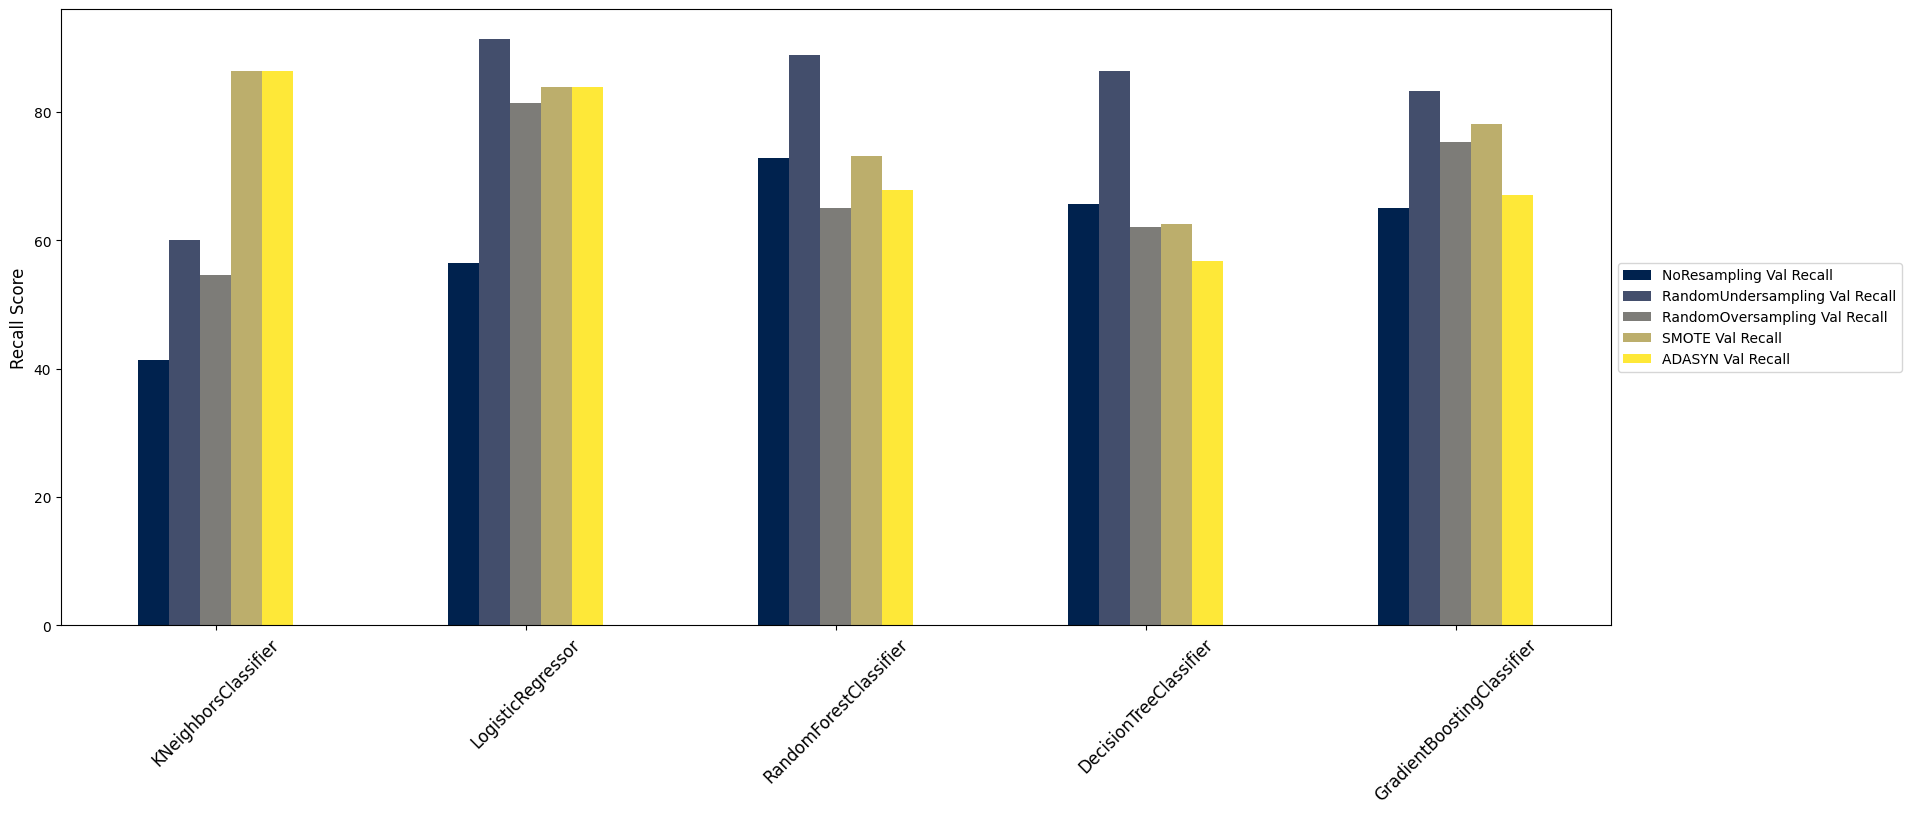

In [ ]:
_, ax = plt.subplots(figsize=(20, 8))
combined_res.plot.bar(ax=ax, cmap='cividis')
ax.set_ylabel('Recall Score', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, fontsize=12)
plt.show()